# **RECCAP Plots**

## Set-up

In [1]:
import numpy as np
import glob
import matplotlib.pyplot as plt
import matplotlib.pylab as pl

import pandas as pd
import xarray as xr

print("DONE")

DONE


In [2]:
datapath = f"/work/uo1227/u301557/ArcticCarbon/data/1D/"            
plotpath = f"/home/u/u301557/ArcticCarbon/plots/Timeseries/"

debug      = False # just controls two print statements in the file_to_dataframe function
save_plots = False

scenario_colors   = {"ssp119" :"#00a9cf",
             "ssp126" :"#003466",
             "ssp245" :"#f69320",
             "ssp370" :"#df0000",
             "ssp585" :"#980002", 
             "historical":"dimgray"}

var_names = {"fgco2":"Surface Downward Mass Flux of Carbon as CO$_2$", 
             "intpp":"Primary Organic Carbon Production by All Types of Phytoplankton", 
             "intpoc":"Particulate Organic Carbon Content", 
             "intdic":"Dissolved Inorganic Carbon Content", 
             "intdoc":"Dissolved Organic Carbon Content", 
             "fric":"Downward Inorganic Carbon Flux at Ocean Bottom", 
             "froc":"Downward Organic Carbon Flux at Ocean Bottom", 
             "ocfriver":"Flux of Organic Carbon into Ocean Surface by Runoff", 
             "cSoil":"Carbon Mass in Soil Pool", 
             "cVeg":"Carbon Mass in Vegetation", 
             "fLuc":"Land-Use Change", # (into atm.)
             "gpp":"Gross Primary Production on Land", # (out of atm.)
             "nbp":"Net Biospheric Production on Land", # (out of atm.)
             "nep":"Net Ecosystem Productivity on Land", # (out of atm.)
             "npp":"Net Primary Production on Land", 
             "ra":"Autotrophic (Plant) Respiration on Land", # (into atm.)
             "rh":"Total Heterotrophic Respiration on Land as Carbon Mass Flux ",
             "terra_carbon": "Terrestrial Carbon (cVeg + cSoil)"}

## General Functions

In [3]:
def modellist_from_files(files, split_chr="_", split_num=-4):
    """
    Extracts unique model identifiers from a list of filenames by splitting each filename 
    using a specified delimiter and selecting a specific portion based on the given index.

    Args:
        files (list of str): A list of filenames (strings) to extract model identifiers from.
        split_chr (str, optional): The character used to split each filename. Defaults to "_".
        split_num (int, optional): The index of the portion of the split filename to extract as the model identifier.
                                    Defaults to -4 (i.e., the 4th-to-last element in the split list).

    Returns:
        list: A list of unique model identifiers extracted from the filenames.
    """
    
    modellist = []
    for file in files:
        model = file.split(split_chr)[split_num]
        modellist.append(model)
    return list(set(modellist))
        

In [4]:
def number_check(array, var):
    """
    Validates whether the values in an array are within an acceptable range for a given variable.
    
    Parameters:
    - array (numpy.ndarray): The array of values to check.
    - var (str): The name of the variable being checked. Determines the acceptable range for validation.
    
    Returns:
    - bool:
        True if all values in the array are within the acceptable range for the given variable, False otherwise.
    """
    
    in_range = True

    if var not in ["fric", "froc", "intpp", "ocfriver"]:
        if np.nanmax(array) > 1000:
            in_range = False
        if np.nanmin(array) < -20:
            in_range = False
    elif var in ["fric", "froc", "intpp", "ocfriver"]:
        if np.nanmax(array) > 1e14:
            in_range = False
        if np.nanmin(array) < -20:
            in_range = False
    
    return in_range

In [5]:
def file_to_dataframe(files, var, scenario, model_name_position=-4, member_name_position=-3, max_nans = 5):
    
    """
    Processes a list of NetCDF files into a single pandas DataFrame containing a specific variable over time.
    
    Parameters:
    - files (list): A list of file paths to NetCDF files.
    - var (str): The variable name to extract from the NetCDF files.
    - scenario (str): The scenario name of the data.
    - model_name_position (int, optional): The position in the file name that contains the model identifier. Default is -4.
    - member_name_position (int, optional): The position in the file name that contains the member identifier. Default is -3.
    - max_nans (int, optional): The maximum number of allowed NaN values for a model's data column before it is excluded from the DataFrame. Default is 5.
    
    Returns:
    - pandas.DataFrame: 
        A DataFrame indexed by year, containing the specified variable for different models. Columns are named 
        by the model identifiers, with suffixes added for member information if necessary. Models are excluded 
        if they contain excessive NaN values or fail the `number_check` validation.
    """
    
     # Define the time range based on the scenario (historical or SSP)
    if scenario == "historical":
        years = np.arange(1850, 2015)
        start_date = pd.to_datetime('1850-01-01')
        end_date = pd.to_datetime('2014-12-31')
    else:
        years = np.arange(2015, 2101)
        start_date = pd.to_datetime('2015-01-01')
        end_date = pd.to_datetime('2100-12-31')

    # Initialize an empty DataFrame indexed by year
    df = pd.DataFrame({"year":years})
    df = df.set_index("year")

    # Iterate through each file to extract and process data
    for file in files:
        try:

            # Extract model and member identifiers from the file name  
            model = file.split("/")[-1].split("_")[model_name_position]
            member = file.split("/")[-1].split("_")[member_name_position]
            
            ds = xr.open_dataset(file)
            ds['time'] = ds.time.values.astype('datetime64[ns]')
            
            # Filter data to match the specified date range
            sliced_ds = ds.where(ds.time <= end_date, drop=True)
            sliced_ds = sliced_ds.where(sliced_ds.time >= start_date, drop=True)

            # Convert time to integer year values
            sliced_ds['time'] = sliced_ds.time.dt.year.values.astype('int')

            # Create a temporary DataFrame for the model's data
            df_model = pd.DataFrame({"year":sliced_ds['time'].values})#sliced_ds['time'].values})
            df_model = df_model.set_index("year")
            df_model[model] = sliced_ds[var].values.squeeze()

            # Merge the temporary DataFrame with the main DataFrame
            df = df.join(df_model, how='left', rsuffix=f'_{member}')

            # Check for missing values and drop the model if too many are present
            nan_count = df[model].isnull().sum()
            if nan_count > max_nans:
                df = df.drop(model, axis=1)
                if debug:
                    print(model, var, scenario, "too many NaNs")

            # Check if data is within a specific rage
            elif not number_check(df[model], var):
                df = df.drop(model, axis=1)
                if debug:
                    print(model, var, scenario, "didnt pass number check")
            
            ds.close()
            
        except Exception as e:
            print(model, e, sliced_ds[var].values.shape, sliced_ds.time.values[:2], sliced_ds.time.values[-2:])
    
    
    return df

In [6]:
def load_data_to_dict_dataframes(variables, scenarios, region):
    """
    Loads data for specified variables and scenarios into a nested dictionary of pandas DataFrames.
    
    Parameters:
    - variables (list): A list of variable names (strings) to process and load.
    - scenarios (list): A list of scenario names (strings) for which data will be loaded (e.g., "historical", "ssp126").
    - region (str): A region identifier to filter the file paths (e.g., "masked", "N60", "glob").
    
    Returns:
    dict:
        A nested dictionary structured as `DF[var][scenario]`, where:
        - `var` (str): A variable name from the `variables` list.
        - `scenario` (str): A scenario name from the `scenarios` list.
        - The value is a pandas DataFrame indexed by year, containing data for the specified variable and scenario.
    """
    
    DF = {}
    for var in variables:
        DF[var] = {}
        for scenario in scenarios[:]:
            files = sorted(glob.glob(datapath + f"{var}/{var}*{region}*{scenario}_1D.nc"))
            DF[var][scenario] = file_to_dataframe(files, var, scenario)
    return DF

In [7]:
def create_model_color_dict(modellist):
    """
    Assigns a unique color to each model in a list, generating a dictionary of model-color mappings.
    
    Parameters:
    - modellist (list): A list of model names (strings) for which colors will be assigned.
    
    Returns:
    - dict:
        A dictionary where each key is a model name from `modellist`, and each value is an RGBA color 
        generated from the `twilight_r` colormap in Matplotlib.

    """
    colors = pl.cm.twilight_r(np.linspace(0,1,len(modellist)))
    model_colors = dict.fromkeys(modellist)
    for cnt, model in enumerate(modellist):
        model_colors[model] = colors[cnt]

    return model_colors

## Plot all variables from all models

- (all models that pass number check and don't have too many NaNs see file_to_dataframe function)

/sw/spack-levante/mambaforge-22.9.0-2-Linux-x86_64-kptncg/lib/python3.10/site-packages/xarray/coding/times.py:724: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/sw/spack-levante/mambaforge-22.9.0-2-Linux-x86_64-kptncg/lib/python3.10/site-packages/xarray/coding/times.py:724: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/sw/spack-levante/mambaforge-22.9.0-2-Linux-x86_64-kptncg/lib/python3.10/site-packages/xarray/core/indexing.py:556: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  array = array.

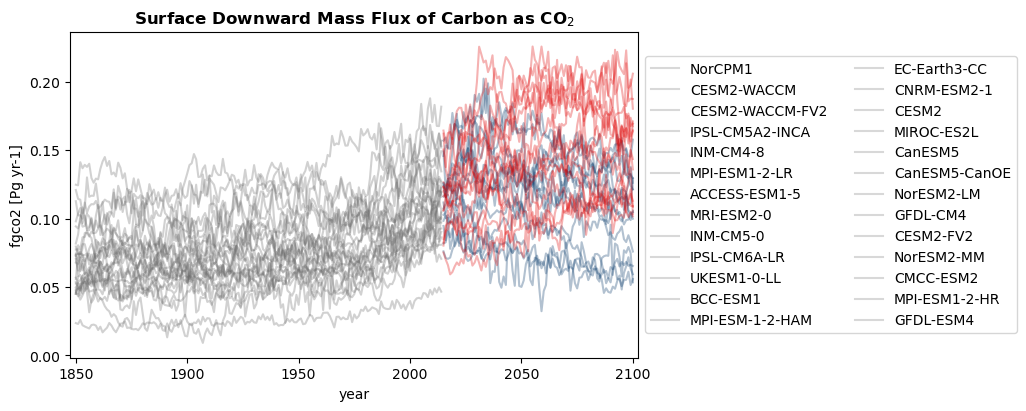

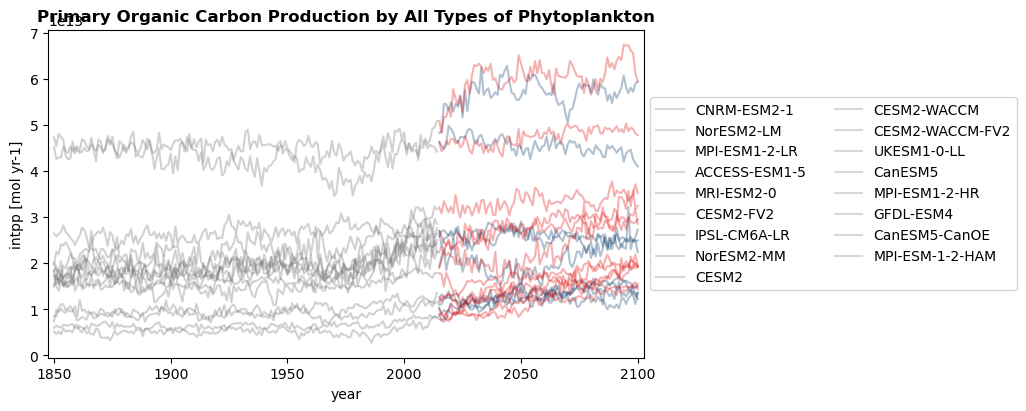

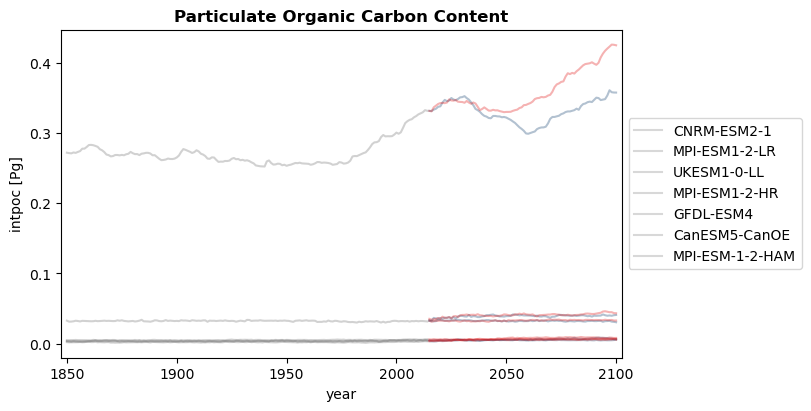

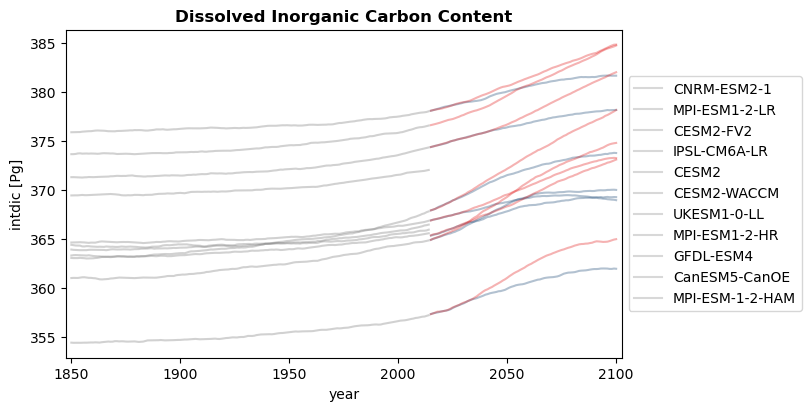

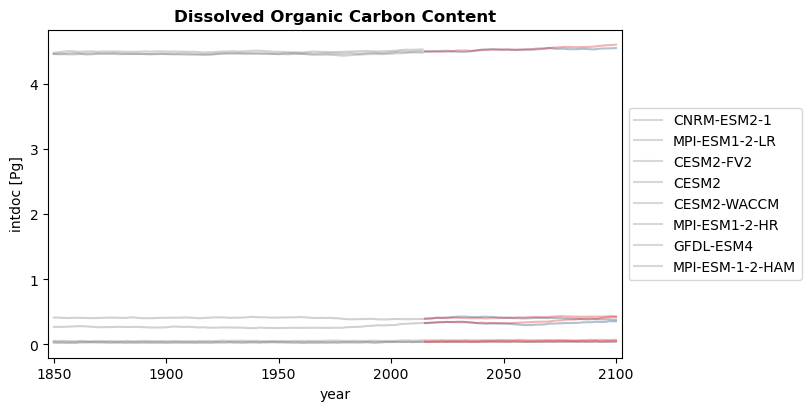

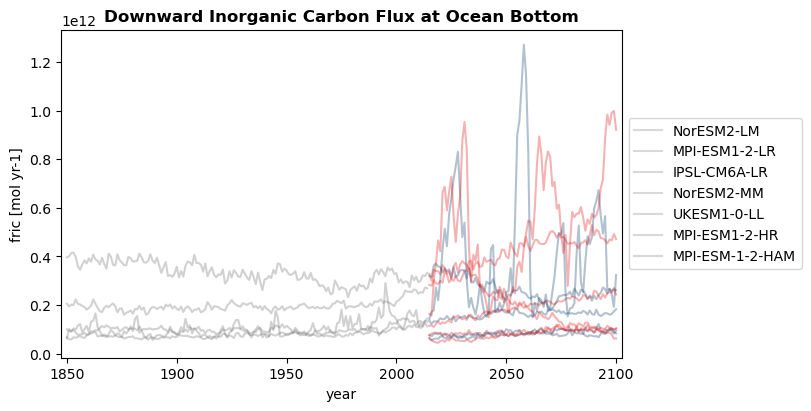

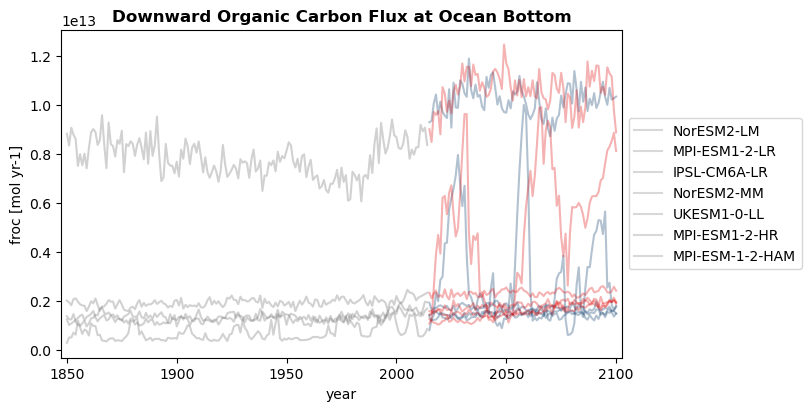

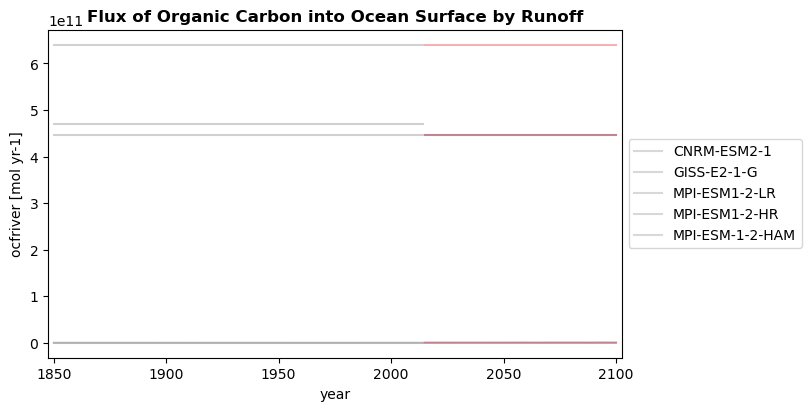

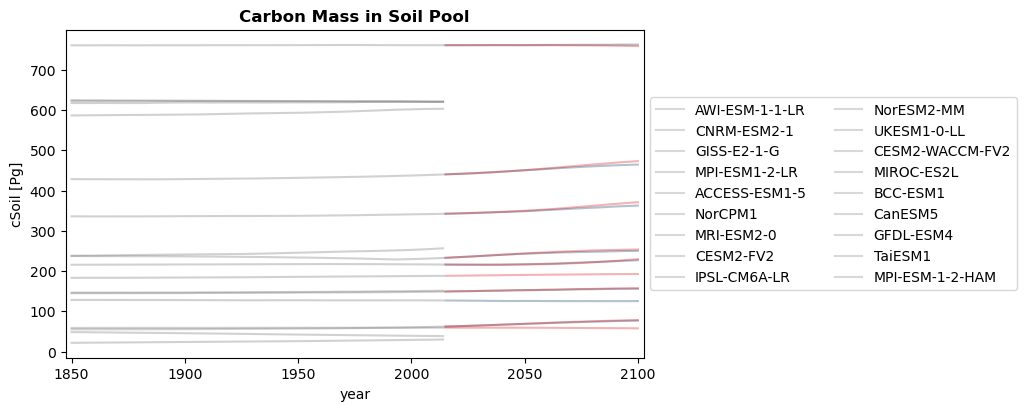

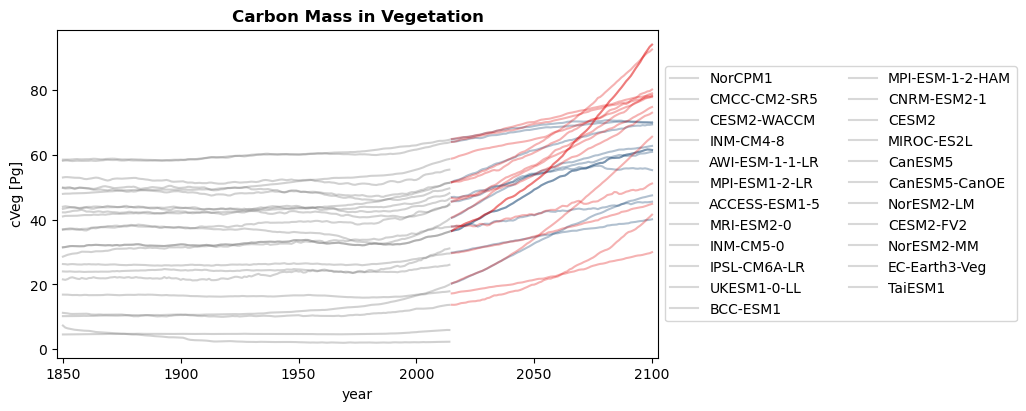

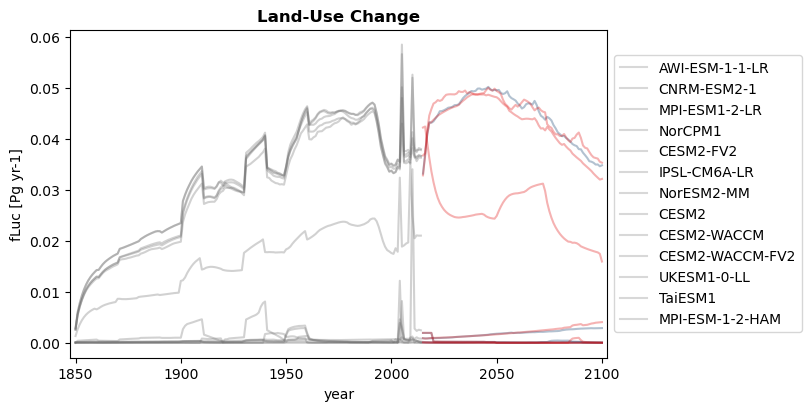

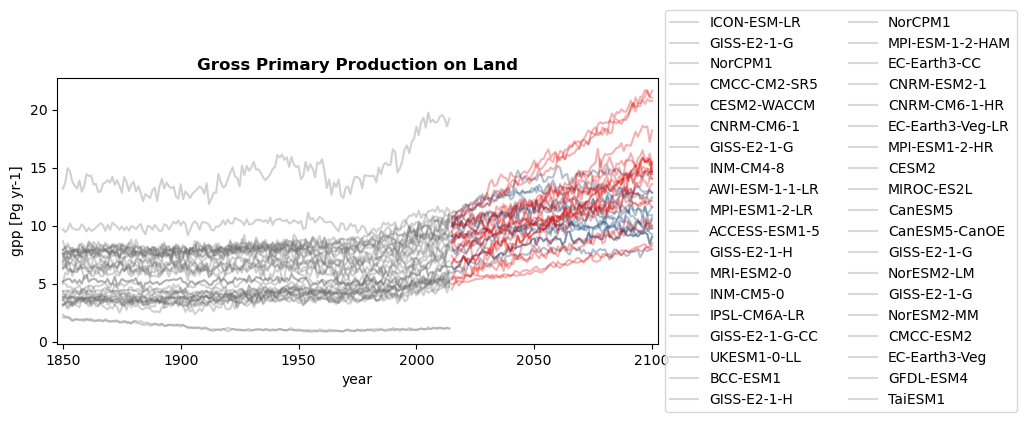

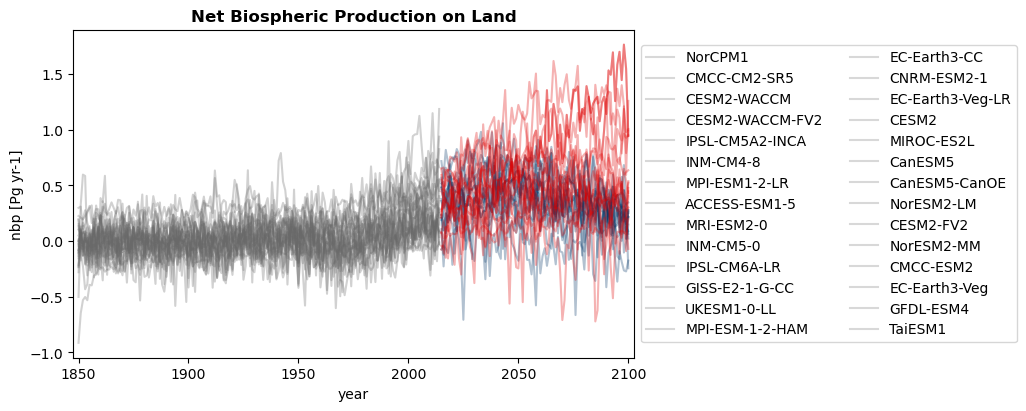

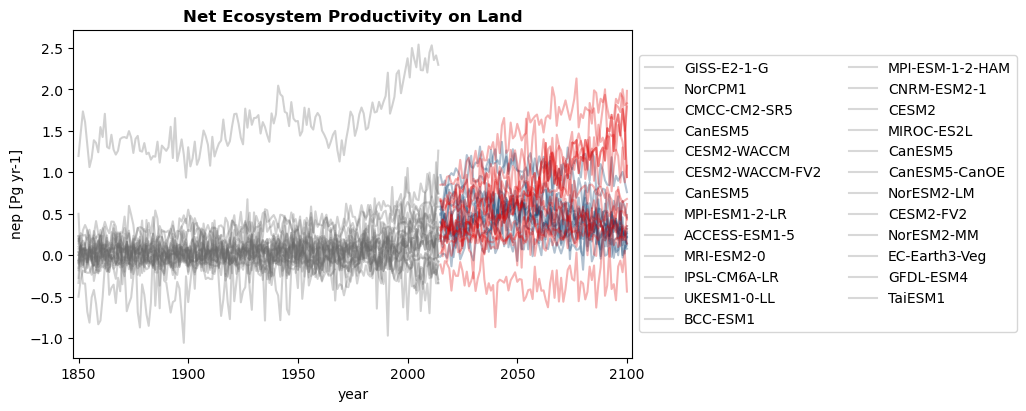

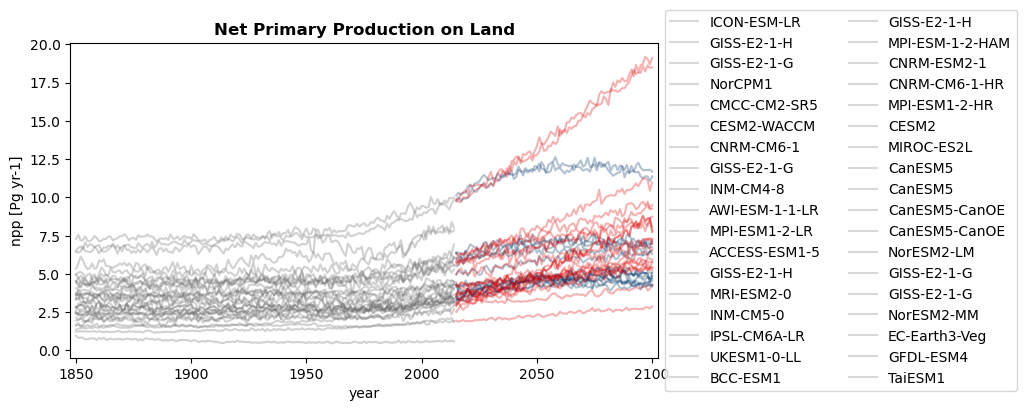

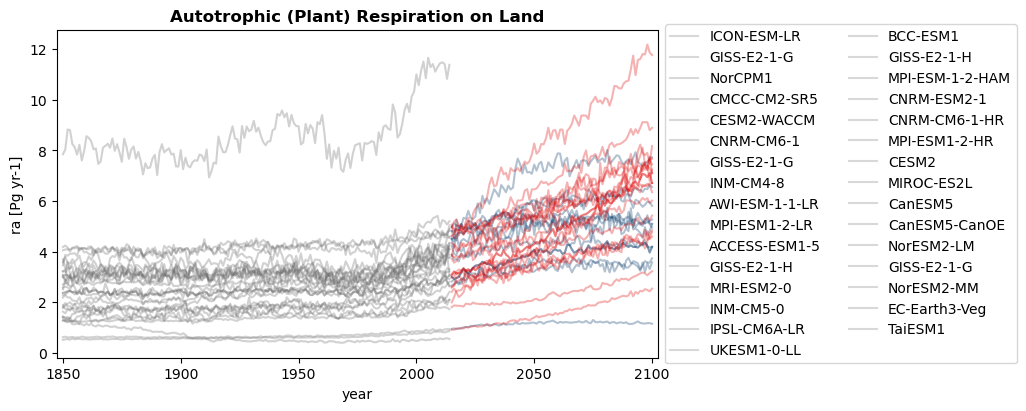

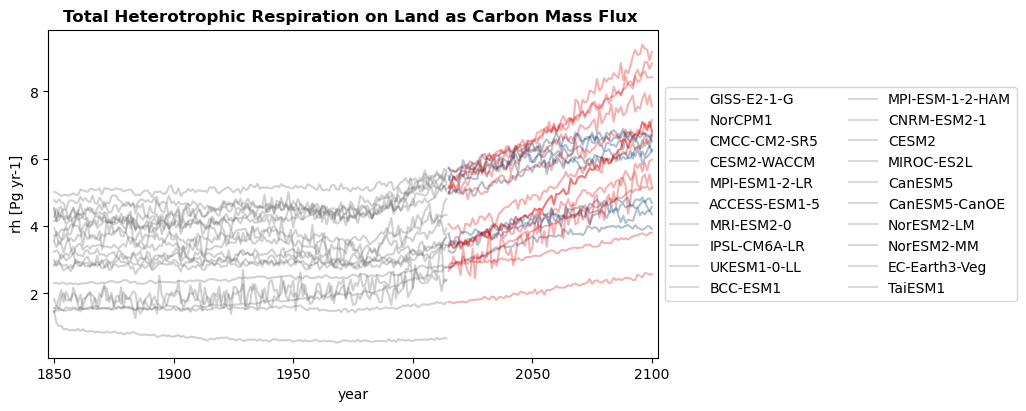

In [9]:
color_code = "scenarios" # plot colored by "models" or "scenarios"
region     = "masked"    # Region ID: "masked" (Arctic Ocean or permafrost region), "N60" (north of 60°N), or "glob" (global)

variables = ["fgco2", "intpp", "intpoc", "intdic", "intdoc", "fric", "froc", "ocfriver", 
             "cSoil", "cVeg", "fLuc", "gpp", "nbp", "nep", "npp", "ra", "rh"]
scenarios = ["historical", "ssp126", "ssp370"]

# If coloring by models, create a colormap for models
if color_code == "models":
    modellist    = sorted(modellist_from_files(glob.glob(datapath + f"*/*{region}*.nc")))
    model_colors = create_model_color_dict(modellist)

# Iterate through all variables
for var in variables[:]:
    fig, ax = plt.subplots(1, figsize=(8,4), constrained_layout=True)
    plotted_models = [] # Track models that have been plotted

    # Loop through the scenarios to plot data
    for scenario in scenarios:

        # Convert data files into a DataFrame
        files = sorted(glob.glob(datapath + f"{var}/{var}_{region}_*_{scenario}_1D.nc"))
        df = file_to_dataframe(files, var, scenario)

        # Plot data for each model in the DataFrame
        for model in df.columns:
            if color_code == "scenarios":
                color = scenario_colors[scenario]
                label_color = "grey"
                alpha = 0.3
            else: # Use model-specific colors
                color = model_colors[model.split("_")[0]]
                label_color = model_colors[model.split("_")[0]]
                alpha=0.5
            ax.plot(df.index, df[model], color=color, alpha=alpha)
            plotted_models.append(model) # Add model to the list of plotted models

    # Add legend entries for the plotted models
    for model in set(plotted_models):
        if color_code == "scenarios":
            label_color = "grey"
        else:
            label_color = model_colors[model.split("_")[0]]
            
        ax.plot(np.nan, np.nan, label=model.split("_")[0], alpha=alpha, color=label_color) # fake legend entry

    # Open the first file to extract variable metadata
    ds = xr.open_dataset(files[0])
    unit = ds[var].attrs["units"]

    # set axis stuff
    ax.set_title(var_names[var], fontweight="bold")
    ax.set_ylabel(f"{var} [{unit}]")
    ax.margins(x=0.01)
    ax.set_xlabel("year")

    # Adjust legend layout based on the number of unique models plotted
    if len(set(plotted_models))>15:
        ncols=2
        fig.set_size_inches(10.15, 4, forward=True)
    else:
        ncols=1
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=ncols)

    if save_plots:
        plt.savefig(plotpath + f"timeseries_{var}_allmodels_color-{color_code}.png", dpi=200)

## Fig.4: Global - cVeg, cSoil, NBP, fgco2

<img src="../figures/RECCAPP-Fig4.png" alt="drawing" width="900"/>

### Parameters

In [10]:
region     = "masked" # Region ID: "masked" (Arctic Ocean or permafrost region), "N60" (north of 60°N), or "glob" (global)

scenarios  = ["historical", "ssp126", "ssp370"]
variables  = ["cVeg", "cSoil", "nbp", "fgco2"]

color_code = "scenarios" # plot colored by "models" or "scenarios"

### Data preparation

In [11]:
# Combine variable data to a dictionary of DataFrames
DF = load_data_to_dict_dataframes(variables, scenarios, region)
        
# Rewrite cVeg and cSoil as difference to 1850 storage
cVeg_Soil_1850  = {}
cVeg_Soil_1850["cVeg"] = {}
cVeg_Soil_1850["cSoil"] = {}

for var in ["cVeg", "cSoil"]:
    for scenario in scenarios:
        for model in DF[var][scenario].columns:
            try:
                if scenario == "historical":
                    cVeg_Soil_1850[var][model] = DF[var][scenario].iloc[0][model] # extract the first year and save it
                
                DF[var][scenario][model] = DF[var][scenario][model] - cVeg_Soil_1850[var][model] # calculate the difference to 1850
            except Exception as e:
                print(e)


/sw/spack-levante/mambaforge-22.9.0-2-Linux-x86_64-kptncg/lib/python3.10/site-packages/xarray/coding/times.py:724: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/sw/spack-levante/mambaforge-22.9.0-2-Linux-x86_64-kptncg/lib/python3.10/site-packages/xarray/coding/times.py:724: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/sw/spack-levante/mambaforge-22.9.0-2-Linux-x86_64-kptncg/lib/python3.10/site-packages/xarray/core/indexing.py:556: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  array = array.

### Data Selection

Select only models that have all scenarios and variables

In [12]:
def model_selection_by_var_and_scenario(DF, selection_variables, selection_scenarios, region):
    """
    Selects models that have complete data for specified variables and scenarios.

    Parameters:
    - DF (dict): A nested dictionary of pandas DataFrames structured as `DF[var][scenario]`, 
                 where `var` is a variable name, and `scenario` is a scenario name.
                 Each DataFrame contains data for different models.
    - selection_variables (list): A list of variable names (strings) to check for model completeness.
    - selection_scenarios (list): A list of scenario names (strings) to check for model completeness.
    - region (str): A region identifier to filter model files ("masked", "N60" or "glob").

    Returns:
    list:
        A list of model names (strings) that have data available for all specified variables and scenarios.
    """
    
    all_models = sorted(modellist_from_files(glob.glob(datapath + f"*/*{region}*.nc")))
    model_selection     = []

    for model in all_models:
        check = True
        for var in variables:
            for scenario in scenarios:
                if model not in DF[var][scenario].columns:
                    check = False
        if check:
            model_selection.append(model)
    
    print(f"Selected models: {model_selection}")
    return model_selection

In [13]:
def filter_dataframe_dict(DF, model_selection, variables, scenarios):

    """
    Filters a nested dictionary of DataFrames to include only selected models.

    Parameters:
    - DF (dict): A nested dictionary of pandas DataFrames structured as `DF[var][scenario]`, 
                 where `var` is a variable name, and `scenario` is a scenario name. 
                 Each DataFrame contains data for different models.
    - model_selection (list): A list of model names (strings) to retain in the filtered DataFrames.
    - variables (list): A list of variable names (strings) to filter within the dictionary.
    - scenarios (list): A list of scenario names (strings) to filter within the dictionary.

    Returns:
    dict:
        A filtered version of the input dictionary `DF`, containing only the models specified 
        in `model_selection`. Models not in the selection are dropped from the DataFrames.
    """

    DF_selection = DF.copy()
    for var in variables:
        for scenario in scenarios:
            if "CanESM5_r1i1p2f1" in DF_selection[var][scenario].columns:
                DF_selection[var][scenario] = DF_selection[var][scenario].drop("CanESM5_r1i1p2f1", axis=1)
            for model in DF[var][scenario].columns:
                if model not in model_selection:
                    DF_selection[var][scenario] = DF_selection[var][scenario].drop(model, axis=1)
    return DF_selection

In [14]:
model_selection = model_selection_by_var_and_scenario(DF, variables, scenarios, region)

# Drop all models that are not selected
DF_selection = filter_dataframe_dict(DF, model_selection, variables, scenarios)

Selected models: ['CNRM-ESM2-1', 'CanESM5', 'IPSL-CM6A-LR', 'MIROC-ES2L', 'MPI-ESM1-2-LR', 'NorESM2-MM', 'UKESM1-0-LL']


### Plotting

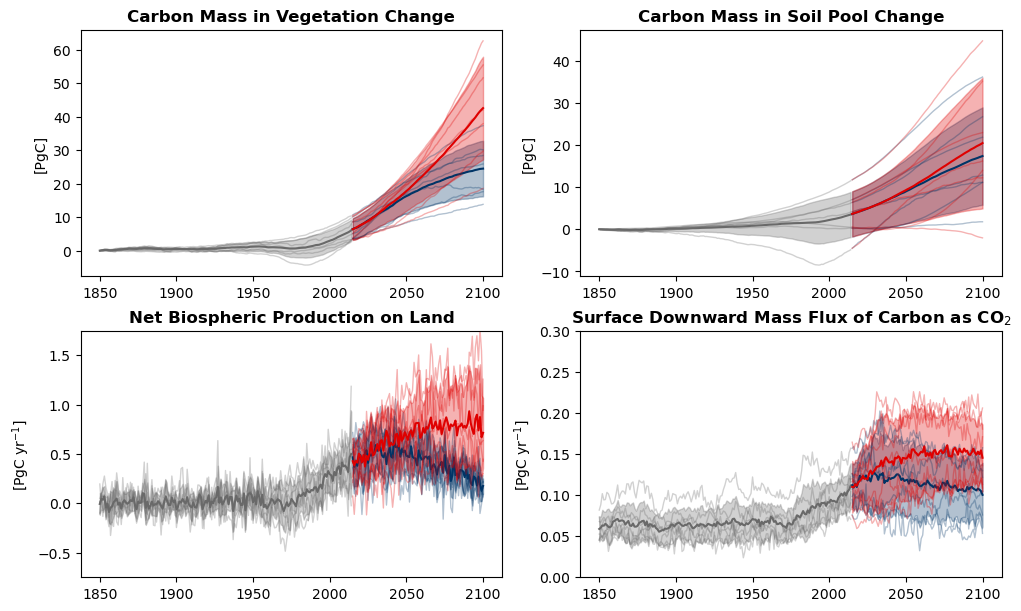

In [15]:
fig, axs = plt.subplots(2,2, figsize=(10,6), constrained_layout=True)

# If coloring by models, create a colormap for models
if color_code == "models":
    model_colors = create_model_color_dict(model_selection)

for ax,var in zip(axs.flatten(), variables):
    ax.set_title(var_names[var], fontweight="bold")
    
    if var in ["cVeg", "cSoil"]:
        ax.set_title(var_names[var] + " Change", fontweight="bold")
        
    for scenario in scenarios:
        for model in model_selection:
            try:
                if color_code == "models":
                    color = model_colors[model]
                    lw = 1
                    alpha=1
                else:
                    color = scenario_colors[scenario]
                    lw = 1
                    alpha=0.3
                    
                ax.plot(DF_selection[var][scenario].index, DF_selection[var][scenario][model], color=color, lw=lw, alpha=alpha)
            except Exception as e:
                print(e)
        if color_code == "scenarios":
            mean = DF_selection[var][scenario].mean(axis=1)
            std = DF_selection[var][scenario].std(axis=1)
            ax.plot(mean, color=color)
            ax.fill_between(DF_selection[var][scenario].index, mean-std, mean+std, color=color, alpha=0.3)
            
for ax in axs[0,:]:
    ax.set_ylabel(f"[PgC]")
    #ax.set_ylim(-20,70)
for ax in axs[1,:]:
    ax.set_ylabel("[PgC yr$^{-1}]$")
axs[1,0].set_ylim(-0.75,1.75)
axs[1,1].set_ylim(0,0.3)

plt.show()

## "Table" 11

<img src="../figures/RECCAP-Tab11.png" alt="drawing" width="900"/>

In [16]:
variables = ["gpp", "npp", "nep", "nbp","fgco2", "fLuc", "cVeg", "cSoil", "terra_carbon"]
scenario  = "historical"

DF = load_data_to_dict_dataframes(variables, [scenario], region)

'GISS-E2-1-G_r1i1p1f2'
'GISS-E2-1-G_r1i1p5f1'
'GISS-E2-1-H_r1i1p5f1'
'NorCPM1_r1i1p1f1'
gpp: mean=7.59, std=3.17
'GISS-E2-1-G_r1i1p1f2'
'GISS-E2-1-H_r1i1p1f2'
'GISS-E2-1-H_r1i1p5f1'
npp: mean=4.49, std=2.11
nep: mean=0.31, std=0.56
nbp: mean=0.27, std=0.23
fgco2: mean=0.11, std=0.03
fLuc: mean=0.02, std=0.02


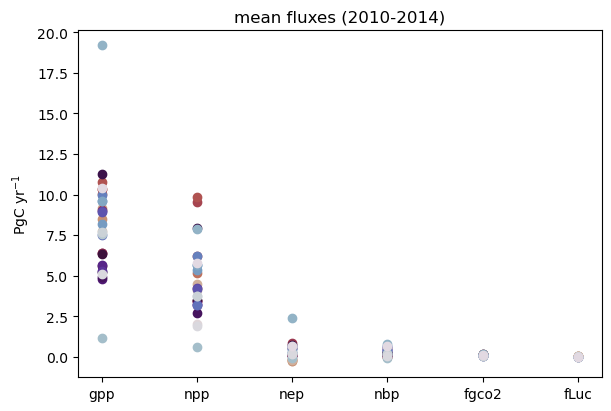

In [19]:
variable_selection = ["gpp", "npp", "nep", "nbp","fgco2", "fLuc"]#, "cVeg", "cSoil", "terra_carbon"

modellist    = sorted(modellist_from_files(glob.glob(datapath + f"*/*{region}*.nc")))
model_colors = create_model_color_dict(modellist)

fig, ax = plt.subplots(1,1, figsize=(6,4), constrained_layout=True)#tight_layout=True, 

for i,var in enumerate(variable_selection):

    df = DF[var][scenario].copy()
    for model, value in df.loc[2010:2014].mean(axis=0).items():
        if value > 50:
            print(model)
        elif value < -50:
            print(model)
        else:
            try:
                ax.scatter(i, value, color=model_colors[model])
            except Exception as e:
                print(e)
        
    print(f"{var}: mean={df.loc[2010:2014].mean(axis=0).mean():1.2f}, std={df.loc[2010:2014].mean(axis=0).std():1.2f}")
ax.set_xticks(range(len(variable_selection)), variable_selection)
ax.set_title("mean fluxes (2010-2014)")
ax.set_ylabel("PgC yr$^{-1}$")
plt.show()

cVeg: mean=37.70, std=17.47
cSoil: mean=306.32, std=241.40
terra_carbon: mean=330.16, std=253.04


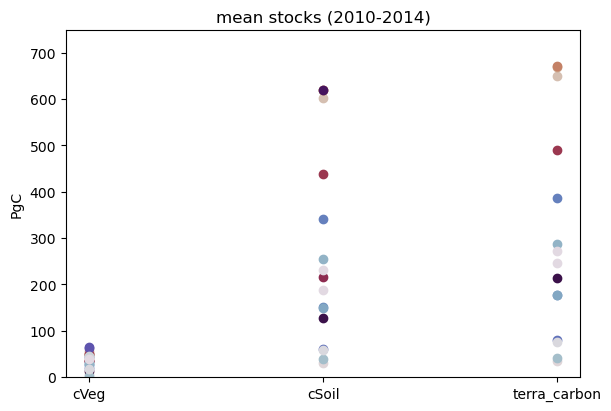

In [20]:
variable_selection = ["cVeg", "cSoil", "terra_carbon"]#, "cVeg", "cSoil", "terra_carbon"
fig, ax = plt.subplots(1,1, figsize=(6,4), constrained_layout=True)#tight_layout=True, 

for i,var in enumerate(variable_selection):#, "npp", "rh","ra"]):
    df = DF[var][scenario].copy()
    for model, value in df.loc[2010:2014].mean(axis=0).items():
        if value > 10000:
            print(model)
        elif value < 0:
            print(model)
        else:
            try:
                ax.scatter(i, value, color=model_colors[model])
            except Exception as e:
                print(e)
        
    print(f"{var}: mean={df.loc[2010:2014].mean(axis=0).mean():1.2f}, std={df.loc[2010:2014].mean(axis=0).std():1.2f}")
ax.set_xticks(range(len(variable_selection)), variable_selection)
ax.set_title("mean stocks (2010-2014)")
ax.set_ylabel("PgC")
ax.set_ylim(0,750)
plt.show()

## Fig. 18: Regional GPP, NBP, Terrestrial Carbon

<img src="../figures/RECCAP-Fig18.png" alt="drawing" width="900"/>

### Set Parameters

In [21]:
region    = "masked"
variables = ["gpp", "nbp", "terra_carbon"]# ["gpp", "npp", "nep", "nbp","fgco2", "fLuc", "cVeg", "cSoil"]
scenarios = ["historical", "ssp126", "ssp370"]
color_code = "scenarios" # models scenarios


### Data Preparation

In [22]:
DF = load_data_to_dict_dataframes(variables, scenarios, region)
model_selection = model_selection_by_var_and_scenario(DF, variables, scenarios, region)

# Drop all models that are not selected
DF_selection = filter_dataframe_dict(DF, model_selection, variables, scenarios)

/sw/spack-levante/mambaforge-22.9.0-2-Linux-x86_64-kptncg/lib/python3.10/site-packages/xarray/coding/times.py:724: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/sw/spack-levante/mambaforge-22.9.0-2-Linux-x86_64-kptncg/lib/python3.10/site-packages/xarray/coding/times.py:724: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/sw/spack-levante/mambaforge-22.9.0-2-Linux-x86_64-kptncg/lib/python3.10/site-packages/xarray/core/indexing.py:556: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  array = array.

Selected models: ['CNRM-ESM2-1', 'IPSL-CM6A-LR', 'MIROC-ES2L', 'MPI-ESM1-2-LR', 'NorESM2-MM', 'UKESM1-0-LL']


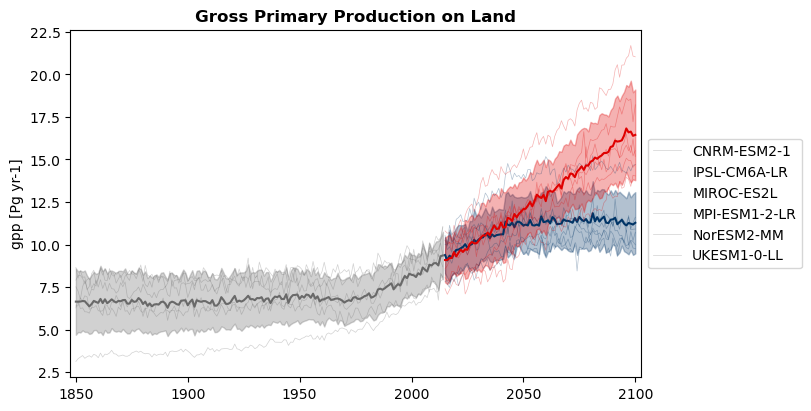

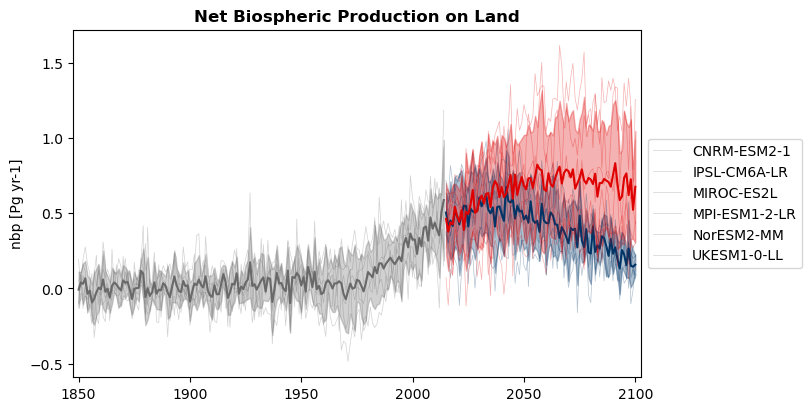

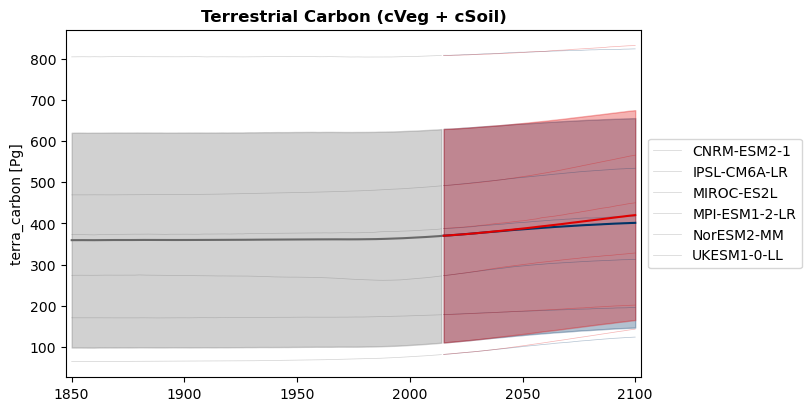

In [23]:
for var in variables:
    fig, ax = plt.subplots(1, figsize=(8,4), constrained_layout=True)

    ax.set_title(var_names[var], fontweight="bold")
    for scenario in scenarios:
        for model in sorted(DF_selection[var][scenario].columns):
            if model == "NorCPM1":
                pass
            if model not in model_selection:
                pass
            else:
                try:
                    if color_code == "models":
                        color = model_colors[model]
                        lw = 1
                        alpha=1
                    else:
                        color = scenario_colors[scenario]
                        lw = 0.5
                        alpha=0.3
                    if scenario == "historical":    
                        ax.plot(DF_selection[var][scenario].index, DF_selection[var][scenario][model], color=color, lw=lw, alpha=alpha, label=model)
                    else:
                        ax.plot(DF_selection[var][scenario].index, DF_selection[var][scenario][model], color=color, lw=lw, alpha=alpha)
                except Exception as e:
                    print(e)
        if color_code == "scenarios":
            mean = DF_selection[var][scenario].mean(axis=1)
            std = DF_selection[var][scenario].std(axis=1)
            ax.plot(mean, color=color)
            ax.fill_between(DF_selection[var][scenario].index, mean-std, mean+std, color=color, alpha=0.3)

    
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ds = xr.open_dataset(glob.glob(datapath + f"{var}/*")[0])
    ax.set_title(var_names[var], fontweight="bold")
    unit = ds[var].attrs["units"]
    ax.set_ylabel(f"{var} [{unit}]")
    ax.margins(x=0.01)

    if save_plots:
        plt.savefig(plotpath + f"selection/timeseries_{var}_model-selection_color-{color_code}.png", dpi=200)